# Preparing Catalogs for Metrics Analysis

In [1]:
# Common Libraries
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import os
import json
import glob
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.colors as colors
# import seaborn as sns
import pandas as pd
import sys
# allows us to import from the custom configs directory w/o affecting deepdisc library imports
sys.path.insert(0, '/u/yse2/deepdisc/configs')
print(sys.path)
# Astropy imports
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import make_lupton_rgb
from typing import List, NamedTuple
from multiprocessing import Pool
from itertools import chain
from scipy.optimize import curve_fit
# Matplotlib and other libraries
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from tqdm import tqdm

['/u/yse2/deepdisc/configs', '/projects/bdsp/miniconda3/envs/ddbtknv/lib/python310.zip', '/projects/bdsp/miniconda3/envs/ddbtknv/lib/python3.10', '/projects/bdsp/miniconda3/envs/ddbtknv/lib/python3.10/lib-dynload', '', '/u/yse2/.local/lib/python3.10/site-packages', '/u/yse2/deepdisc/src', '/projects/bdsp/miniconda3/envs/ddbtknv/lib/python3.10/site-packages']


In [ ]:
root_dir = os.path.expanduser('~/lsst_data/')
folder = 'annotations_lvl5'
run_name = 'lsst5_30k_4h200_bs192_ep50'
test_data_fn = f'{root_dir}{folder}/test_8k.json'
test_data = pd.read_json(test_data_fn)
print(f"Loaded test data from {test_data_fn} with {len(test_data)} images.")

# Getting LSST Truth and Detection Catalog Info of Area Covered by Test Set

Since the test set only has 8000 cutouts, it covers a much a smaller area of the overall sky area we have available. As such, we need to find the truth and detected objects that exist within each of these cutouts. We can do this trivially since each cutout has the keys: `truth_cat_path` and `det_cat_path` that lead to a catalog containing the ground truth objects and detected objects respectively within that cutout. 

In [ ]:
det_cat_paths = test_data.det_cat_path.tolist()
truth_cat_paths = test_data.truth_cat_path.tolist()
file_names = test_data.file_name.tolist()

In [7]:
def read_json(path, file_name):
    return pd.read_json(path).assign(file_name=file_name) # add col with file name for each cat

def create_all_cats(cat_paths, file_names, cat_type):
    print(f"Processing {len(cat_paths)} {cat_type} catalog files in test set which should match the {len(test_data)} cutouts in test set.")
    cpu_count = len(os.sched_getaffinity(0))
    print(f"Using {cpu_count} CPUs to load in {len(cat_paths)} dataframes...")
    with Pool(processes=cpu_count) as pool:
        all_cats = pool.starmap(read_json, zip(cat_paths, file_names))
    print(f"Successfully loaded {len(all_cats)} {cat_type} catalogs which should again match the {len(test_data)} cutouts in test set.")
    print(f"The total number of LSST {cat_type} objects across the same area as the test set is (including potential duplicates): {sum([len(cat) for cat in all_cats])}")
    return all_cats

In [ ]:
all_det_cats = create_all_cats(det_cat_paths, file_names, 'detection') # ~17.5 s w/ 32 CPUs

Processing 8571 detection catalog files in test set which should match the 8571 cutouts in test set.
Using 32 CPUs to load in 8571 dataframes...


In [7]:
all_truth_cats = create_all_cats(truth_cat_paths, 'truth') # ~41s w/ 32 CPUs

Processing 8571 truth catalog files in test set which should match the 8571 cutouts in test set.
Using 32 CPUs to load in 8571 dataframes...
Successfully loaded 8571 truth catalogs which should again match the 8571 cutouts in test set.
The total number of LSST truth objects across the same area as the test set is (including potential duplicates): 1190077


In [8]:
all_det_cats[5]

,clean,mag_y,psf_fwhm_r,patch,mag_g,snr_y_cModel,snr_i_cModel,extendedness,mag_z_cModel,mag_u,...,mag_r,tract,mag_u_cModel,psf_fwhm_g,snr_g_cModel,psf_fwhm_y,ra,mag_i,cutout_x,cutout_y
0,True,26.118981,0.849006,"0,0",27.843334,0.888576,7.724825,0,25.120004,29.071679,...,26.817746,3256,28.509775,0.897332,2.036781,1.165917,51.415989,25.733061,46.890235,52.677475
1,True,24.498444,0.851600,"0,0",27.001259,4.163064,14.415524,0,25.104548,26.550808,...,26.185617,3256,26.452065,0.885042,4.979995,1.165919,51.415414,25.055598,54.123365,106.336047
2,True,23.175374,0.849927,"0,0",23.292234,13.840290,69.615816,1,22.862648,23.425320,...,23.280424,3256,23.134348,0.880423,141.302217,1.164576,51.411999,23.367901,100.066441,111.854943
3,True,25.278589,0.854691,"0,0",27.647576,1.874402,7.491906,1,24.793155,26.664129,...,27.258756,3256,26.324374,0.880422,2.620869,1.164741,51.410110,25.933101,125.286164,134.222374
4,True,26.283804,0.849058,"0,0",26.885120,1.076425,1.964117,1,25.259867,28.922489,...,27.582306,3256,27.562501,0.897335,6.376415,1.166258,51.418940,27.183071,7.518083,14.033777
5,True,27.254614,0.848819,"0,0",25.949210,0.578475,4.038777,1,26.626478,25.697995,...,26.063617,3256,25.697575,0.897335,12.460572,1.165901,51.418295,26.466873,16.094239,26.155134
6,True,25.955153,0.853134,"0,0",26.944979,1.121391,2.175269,0,NaN,28.967999,...,27.536103,3256,29.978628,0.895885,5.145243,1.166258,51.413854,27.142260,75.650192,50.694160
7,True,25.502125,0.859945,"0,0",26.965216,1.310367,2.527285,1,NaN,27.647684,...,29.654461,3256,27.613816,0.880421,5.104333,1.165367,51.410511,27.083787,119.987742,123.876297
8,True,27.792826,0.859945,"0,0",26.924830,0.042302,2.987487,1,25.984114,28.292132,...,NaN,3256,28.336273,0.885053,5.507847,1.166258,51.416012,26.797147,45.765790,139.950651
9,True,24.730687,0.851861,"0,0",25.443697,3.324235,10.553304,1,24.908183,25.779641,...,25.721360,3256,25.641363,0.895878,20.094099,1.164652,51.414733,25.416435,64.253618,4.041911


In [9]:
all_truth_cats[5]

,id,mag_r,patch,flux_g,tract,mag_z,dec,mag_y,rv,ra,...,ellipticity_2_true,size_disk_true,ellipticity_1_true,bulge_to_total_ratio_u,bulge_to_total_ratio_g,bulge_to_total_ratio_r,bulge_to_total_ratio_z,bulge_to_total_ratio_y,cutout_x,cutout_y
0,10252628048,28.496267,"0,0",4.916702,3256,26.826593,-41.595325,26.513708,3.1,51.409893,...,-0.176978,0.161937,0.065590,0.047988,0.096572,0.164494,0.188210,0.199842,128.945681,55.352002
1,10252657732,28.406851,"0,0",4.928853,3256,26.703934,-41.592929,26.343491,3.1,51.417757,...,-0.147302,0.152574,-0.122857,0.000000,0.000000,0.000000,0.000000,0.000000,22.659198,97.479638
2,10252340453,28.371241,"0,0",8.583076,3256,27.038517,-41.594278,26.943630,3.1,51.411993,...,0.031606,0.116248,0.001731,0.000000,0.000000,0.000000,0.000000,0.000000,100.500622,73.925935
3,10252375187,28.114119,"0,0",13.727154,3256,26.956146,-41.592612,26.937361,3.1,51.415365,...,-0.090336,0.086533,-0.307650,0.000000,0.000000,0.000000,0.000000,0.000000,54.818338,103.484783
4,10252711813,28.570383,"0,0",11.994190,3256,27.718304,-41.597515,27.686623,3.1,51.416859,...,0.016729,0.093805,-0.020570,0.495171,0.505748,0.557099,0.688295,0.711420,35.525047,15.040665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,10270702013,28.641396,"0,0",7.375359,3256,28.808399,-41.592062,28.748672,3.1,51.418593,...,-0.547011,0.089938,-0.340925,0.000000,0.000000,0.000000,0.000000,0.000000,11.258208,112.986415
152,10270205016,27.843159,"0,0",11.119020,3256,27.641533,-41.590722,27.616383,3.1,51.411025,...,-0.048780,0.148753,-0.103730,0.057103,0.452467,0.711013,0.809498,0.817769,112.935474,138.078468
153,10270222447,27.645451,"0,0",18.898119,3256,27.753733,-41.595311,27.699511,3.1,51.413697,...,0.007548,0.147661,-0.069770,0.072362,0.404206,0.546928,0.617605,0.630955,77.727649,55.108718
154,10270234084,27.807224,"0,0",15.080068,3256,27.122614,-41.593258,26.985540,3.1,51.418996,...,-0.094252,0.523422,-0.010744,0.475318,0.548213,0.667687,0.879122,0.888470,6.044783,91.392096


Text(0.5, 1.0, 'Detections and Ground Truth Objects of Random Cutout #5')

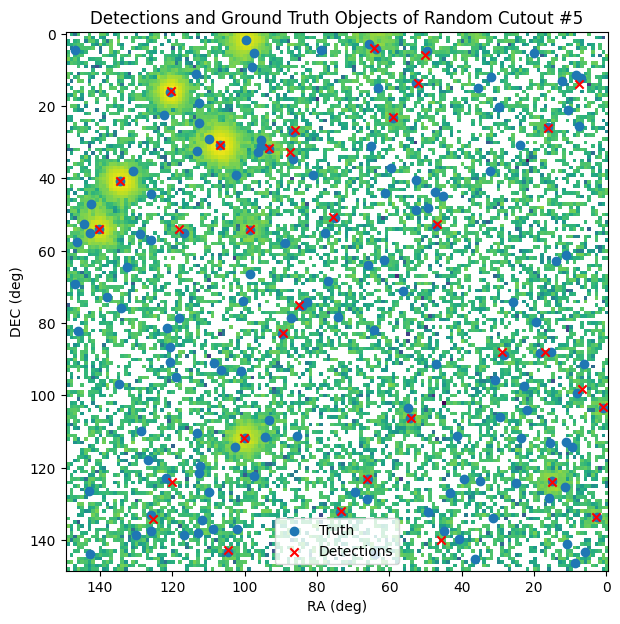

In [36]:
# let's do a quick check of the detections vs truth for a random cutout
plt.figure(figsize=(7,7))
plt.imshow(np.load(test_data.iloc[5].file_name)[3, :, :], norm=colors.LogNorm())
plt.scatter(all_truth_cats[5]['cutout_x'].values, all_truth_cats[5]['cutout_y'].values, label='Truth')
plt.scatter(all_det_cats[5]['cutout_x'].values, all_det_cats[5]['cutout_y'].values, marker='x', c='red', label='Detections')
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.gca().invert_xaxis()
plt.ticklabel_format(style='plain', useOffset=False) # prevent scientific notation
plt.legend()
plt.title('Detections and Ground Truth Objects of Random Cutout #5')

Since we have $>200k$ objects and ~$1.1$ million objects across the detection catalogs and truth catalogs respectively, we need a fast way to combine all of these objects into one big dataframe. Using `pd.concat()` for a large number of dataframes is really slow because it repeatedly copies DataFrame indices and builds the result incrementally. Instead, we use `itertools.chain.from_iterable()` to efficiently flatten each column across all data, then construct a single DataFrame from the resulting dictionary. This is way faster and more memory-efficient.

In [8]:
def concat_all_cats(all_cats, cat_type):
    # build dict col-by-col
    col_names = all_cats[0].columns.tolist()
    print(f"Columns of {cat_type} catalog: {col_names}")
    df_dict = {}
    for col in col_names:
        df_dict[col] = list(chain.from_iterable(df[col] for df in all_cats))
    full_cat = pd.DataFrame(df_dict)
    print(f"Successfully concatenated {cat_type} catalogs into one catalog with {len(full_cat)} total objects.")
    return full_cat

## LSST Detection Catalog

In [9]:
full_det_cat = concat_all_cats(all_det_cats, 'detection') # took ~20.5s

Columns of detection catalog: ['clean', 'mag_y', 'psf_fwhm_r', 'patch', 'mag_g', 'snr_y_cModel', 'snr_i_cModel', 'extendedness', 'mag_z_cModel', 'mag_u', 'mag_r_cModel', 'good', 'mag_i_cModel', 'psf_fwhm_u', 'dec', 'blendedness', 'y', 'parentObjectId', 'psf_fwhm_z', 'snr_u_cModel', 'snr_z_cModel', 'mag_y_cModel', 'objectId', 'snr_r_cModel', 'psf_fwhm_i', 'x', 'mag_g_cModel', 'mag_z', 'mag_r', 'tract', 'mag_u_cModel', 'psf_fwhm_g', 'snr_g_cModel', 'psf_fwhm_y', 'ra', 'mag_i', 'cutout_x', 'cutout_y']
Successfully concatenated detection catalogs into one catalog with 271146 total objects.


In [10]:
print(len(np.unique(full_det_cat.objectId.values)), "unique objects in detection catalog that covers the same cutout areas as the test set.")

271146 unique objects in detection catalog that covers the same cutout areas as the test set.


In [57]:
# from this schema: https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md
# we also filter out objs that aren't 'clean'
# 'clean' is only True if the source has no flagged pixels (such as interpolated, saturated, edge, clipped) 
# and isn't skipped by the deblender (due to blending/segmentation failures)
clean_det_cat = full_det_cat[(full_det_cat['clean'] == True)]
print(len(np.unique(clean_det_cat.objectId.values)), f"unique objects in the clean detection catalog removing {(1 - len(clean_det_cat)/len(full_det_cat))*100:.2f}% of sources.")

270107 unique objects in the clean detection catalog removing 0.38% of sources.


In [ ]:
# let's save this clean det catalog since we no longer need to filter it again
clean_det_cat.to_json(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/test_cats/test_det_cat.json', orient='records')

### Choosing Limiting Magnitude

Text(0.5, 1.0, 'Mag $i$ Distribution of LSST Detection Catalog Objects (270107 objs)')

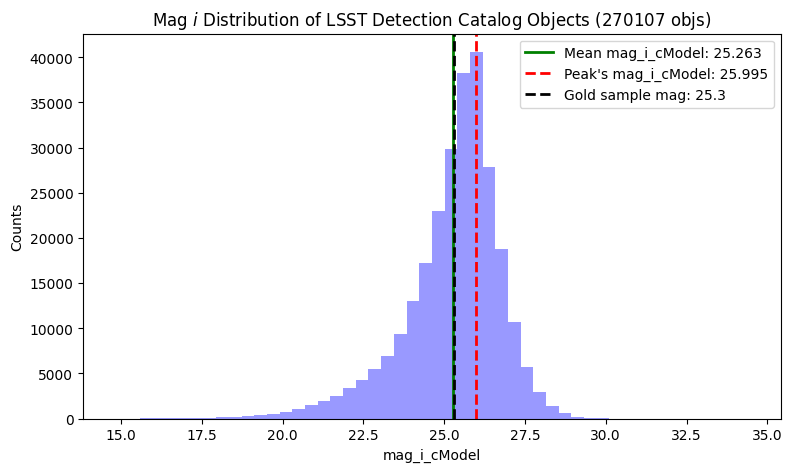

In [13]:
counts, bin_edges = np.histogram(clean_det_cat[np.isfinite(clean_det_cat['mag_i_cModel'])]['mag_i_cModel'], bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
plt.figure(figsize=(9, 5))
plt.xlabel('mag_i_cModel')
plt.ylabel('Counts')
plt.axvline(np.mean(clean_det_cat['mag_i_cModel']), color='green', linestyle='solid', 
            linewidth='2', label=f'Mean mag_i_cModel: {np.mean(clean_det_cat["mag_i_cModel"]):.3f}')
plt.axvline(peak_mag, color='red', linestyle='dashed', linewidth='2',
            label=f"Peak's mag_i_cModel: {peak_mag:.3f}")
plt.axvline(25.3, color='black', linestyle='--', linewidth='2', label=f'Gold sample mag: 25.3')
plt.hist(clean_det_cat['mag_i_cModel'], bins=50, alpha=0.4, color='blue')
plt.legend()
plt.title(f"Mag $i$ Distribution of LSST Detection Catalog Objects ({len(clean_det_cat)} objs)")

Since we'll be using the LSST detection catalog as our benchmark, we need to either use the nominal value for, or empirically find, the limiting magnitude. Let's explore both cases.

Since we're not using 10-year simulated coadds, we will have to calculate the mag limit using the nominal 5-sigma mag provided by [Rubin's key numbers](https://rubinobservatory.org/for-scientists/rubin-101/key-numbers).

In [14]:
# same for all SNR levels
def nom_mag_limit(baseline_mag_5sigma_10yr, years, baseline_snr=5, target_snr=5):
    """
    Calculate truth catalog magnitude cut at Rubin's nominal 5-sigma depth adjusted 
    for the specified number of observation years. This cut is intended to be used consistently for defining the faint 
    limit of the truth sample for analysis (e.g., completeness).

    Parameters:
    baseline_mag_5sigma_10yr (float): 10-year 5-sigma depth (e.g., 26.8 for i-band) from Rubin key values
    years (float): Analysis time baseline in years
    
    Returns:
    float: Magnitude cut for truth catalog
    """
    time_factor = np.sqrt(10 / years) # represents (sqrt(N_obs_10yr) / sqrt(N_obs_years))
    # delta_mag = 2.5 * log10(SNR_ratio)
    # SNR_ratio corresponds to 1 / time_factor for reaching the same SNR
    m_cut = baseline_mag_5sigma_10yr - 2.5 * np.log10(time_factor)
    # adjust for change in SNR threshold
    snr_ratio = baseline_snr / target_snr
    final_mcut = m_cut + 2.5 * np.log10(snr_ratio)
    return final_mcut

baseline_mag_5sigma_10yr_i = 26.8  # From Rubin key numbers
years = 5
given_mag_limit = nom_mag_limit(baseline_mag_5sigma_10yr_i, years)
print(f"Limiting Magnitude: mag_i <= {given_mag_limit:.3f}")  # 26.42

Limiting Magnitude: mag_i <= 26.424


Text(0.5, 1.0, 'Mag $i$ Distribution of LSST Detection Catalog Objects (270107 objs)')

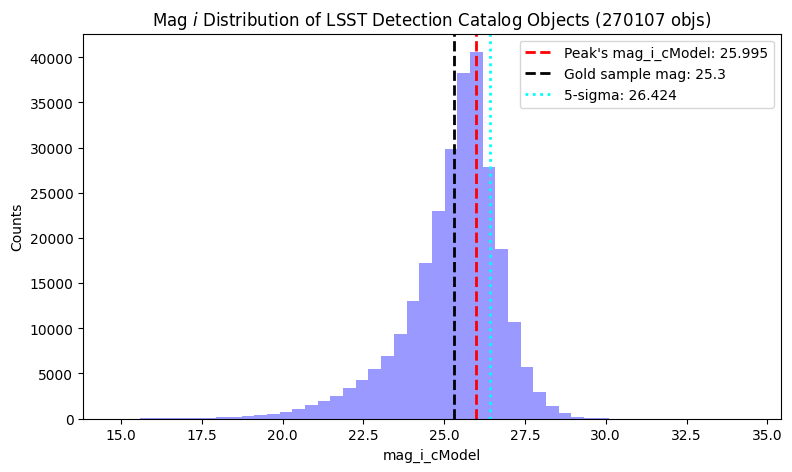

In [203]:
counts, bin_edges = np.histogram(clean_det_cat[np.isfinite(clean_det_cat['mag_i_cModel'])]['mag_i_cModel'], bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
plt.figure(figsize=(9, 5))
plt.xlabel('mag_i_cModel')
plt.ylabel('Counts')
# plt.axvline(np.mean(clean_det_cat['mag_i_cModel']), color='green', linestyle='solid', 
#             linewidth='2', label=f'Mean mag_i_cModel: {np.mean(clean_det_cat["mag_i_cModel"]):.3f}')
plt.axvline(peak_mag, color='red', linestyle='dashed', linewidth='2',
            label=f"Peak's mag_i_cModel: {peak_mag:.3f}")
plt.axvline(25.3, color='black', linestyle='--', linewidth='2', label=f'Gold sample mag: 25.3')
plt.axvline(given_mag_limit, color='cyan', linestyle=':', linewidth='2', label=f'5-sigma: {given_mag_limit:.3f}')
plt.hist(clean_det_cat['mag_i_cModel'], bins=50, alpha=0.4, color='blue')
plt.legend()
plt.title(f"Mag $i$ Distribution of LSST Detection Catalog Objects ({len(clean_det_cat)} objs)")

To empirically find the mag limit from the LSST detection catalog, we fit a power law to the "bright", complete portion of the LSST detections' magnitude distribution and identify the point where the observed object counts drop to 80% of the expected fit. Thus, we're defining the completeness cut-off for our truth catalog in a more data-driven approach.

In [15]:
def find_mag_limit_power_law(mags, mag_col='mag_i_cModel', 
                                   fit_range=(21.0, 26.0), 
                                   threshold=0.80,
                                   bins=50):
    """
    Fits a power law to the mag distribution and finds the 80% completeness limit.
    Parameters:
        mags: Array-like of mags from the detection catalog
        mag_col: Name of the mag column 'mag_i_cModel'
        fit_range: Tuple (min_mag, max_mag) defining the "bright", complete region (Troxel et al. 2023 uses ~21-26)
        threshold: Ratio (observed / predicted) defining limit (0.80)
        bins: Num of histogram bins/bin width
    """
    # get rid of NaNs or infs
    valid_mags = mags[np.isfinite(mags)]
    counts, bin_edges = np.histogram(valid_mags, bins=bins)
    # now we have counts (number of sources in each mag bin)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # let's actually define the power law with N being num of sources per mag bin
    # since N(mag) usually increases exponentially with mag, we fit in log space
    # making the fit linear and more stable
    # N(mag) ~ 10^(a*mag + b) -> log_10(N) = a*mag + b
    def power_law_log(m, slope, intercept):
        return slope * m + intercept
    # only select bins where bin_centers are within range we want
    mask_fit = (bin_centers >= fit_range[0]) & (bin_centers <= fit_range[1])
    mags_to_fit = bin_centers[mask_fit]
    counts_to_fit = counts[mask_fit]
    # log space for fitting
    log_counts_to_fit = np.log10(counts_to_fit)
    # fit straight line to log-counts
    popt, pcov = curve_fit(power_law_log, mags_to_fit, log_counts_to_fit)
    slope_fit, intercept_fit = popt
    
    # now we calculate pred counts for all bins based on fit
    pred_log_counts = power_law_log(bin_centers, slope_fit, intercept_fit)
    pred_counts = 10**pred_log_counts
    # observed / pred
    completeness = counts / pred_counts
    # first bin AFTER fit_range where ratio drops below threshold
    # only search mags fainter than fit_range max
    search_mask = bin_centers > fit_range[1]
    limit_mag = np.max(bin_centers) # if we never find it, set to max mag
    # loop thru the faint end of the mags
    for mag, ratio in zip(bin_centers[search_mask], completeness[search_mask]):
        print(f"Mag: {mag}, Completeness Ratio: {ratio}")
        if ratio < threshold: 
            limit_mag = mag # grabbing center of bin where it drops below threshold (cld interpolate between bins instead)
            break
    if limit_mag == np.max(bin_centers):
        print(f"Warning: didn't find a mag where completeness drops below threshold {threshold}; setting limit to max mag")
    
    plt.figure(figsize=(10, 6))
    plt.semilogy(bin_centers, counts, drawstyle='steps-mid', label='Detected Counts', color='black')
    # power law fit we extrapolated
    plt.semilogy(bin_centers, pred_counts, '--', label=f'Power Law Fit', color='red')
    plt.axvline(limit_mag, color='blue', linestyle='--', linewidth=2, 
                label=f'{int(threshold*100)}% Completeness: {limit_mag:.2f} mag')
    plt.axvspan(fit_range[0], fit_range[1], color='green', alpha=0.1, label=f'Fit Region ({fit_range[0]}, {fit_range[1]})')
    plt.xlabel(f'{mag_col}')
    plt.ylabel('Num of sources (log scale)')
    plt.title(f'Depth Limit via Power Law Fit\nCutoff: {limit_mag:.3f}')
    plt.legend()
    plt.grid(True, which="both", alpha=0.2)
    return limit_mag

Mag: 26.01949881749525, Completeness Ratio: 0.8098184508560063
Mag: 26.06855405736175, Completeness Ratio: 0.7730863375065012


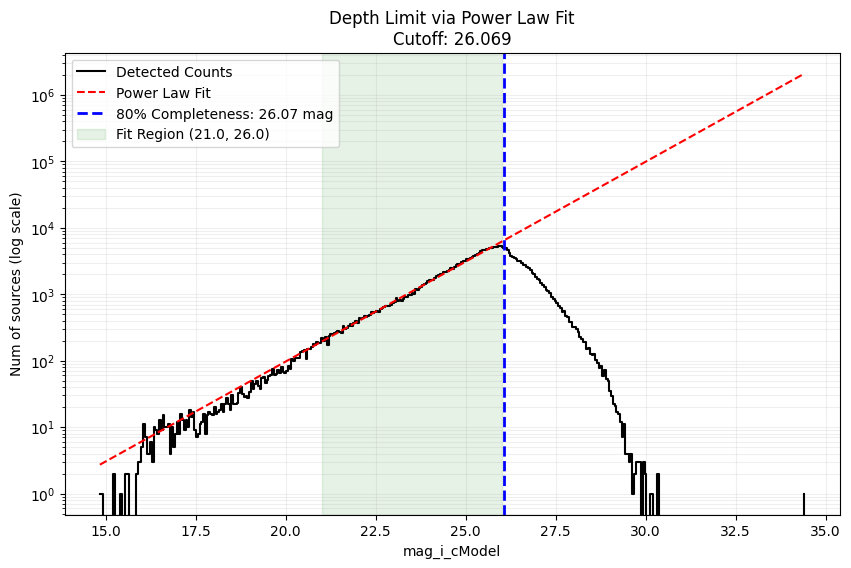

In [16]:
mag_limit = find_mag_limit_power_law(clean_det_cat['mag_i_cModel'].values, 
                                     mag_col='mag_i_cModel', 
                                     fit_range=(21.0, 26.0),
                                     threshold=0.80, 
                                     bins=400)

Great, the detected counts follow the power law really well in the (21, 26) region. With our LSST detection catalog, `26.07` seems to be the detection limit of the pipeline. The sharp drop-off right after 26 also confirms that the pipeline had a hard time resolving objects from background noise.

Text(0.5, 1.0, 'Mag $i$ Distribution of LSST Detection Catalog Objects (270107 objs)')

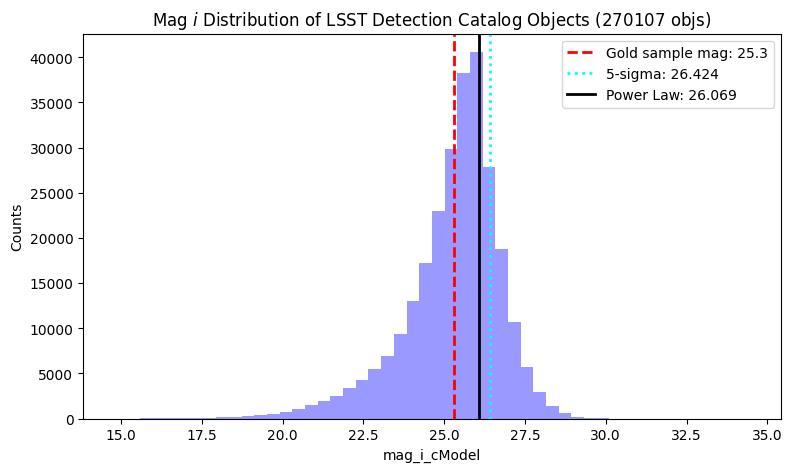

In [223]:
counts, bin_edges = np.histogram(clean_det_cat[np.isfinite(clean_det_cat['mag_i_cModel'])]['mag_i_cModel'], bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
plt.figure(figsize=(9, 5))
plt.xlabel('mag_i_cModel')
plt.ylabel('Counts')
plt.axvline(25.3, color='red', linestyle='--', linewidth='2', label=f'Gold sample mag: 25.3')
plt.axvline(given_mag_limit, color='cyan', linestyle=':', linewidth='2', label=f'5-sigma: {given_mag_limit:.3f}')
plt.axvline(mag_limit, color='black', linestyle='solid', linewidth='2', label=f'Power Law: {mag_limit:.3f}')
plt.hist(clean_det_cat['mag_i_cModel'], bins=50, alpha=0.4, color='blue')
plt.legend()
plt.title(f"Mag $i$ Distribution of LSST Detection Catalog Objects ({len(clean_det_cat)} objs)")

So, which one do we choose to do our analysis with: **26.07** or **26.42**?

Our main goal is focused on analyzing and characterizing blends. To do this effectively, we have to isolate blending systematics from the detector's sensitivity. By targeting the empirical completeness right where the LSST pipeline's recovery rate begins to lower, we make sure that we're analyzing a space where isolated objects should be detected. Knowing that, we can attribute failures (merged objects or missed detections) primarily to blending rather than low SNR. If we push to the 5-sigma depth of 26.42, we could conflate blending failures with detection failures caused by the faintness. Additionally, if we use the conservative (high purity, low false positives) "gold sample" magnitude of 25.3, we will be ignoring the fact that the pipeline did successfully detect objects between 25.3 and 26.4. Thus, we set our limiting magnitude to be the empirically derived **26.07**.

## LSST Truth Catalog

In [17]:
full_truth_cat = concat_all_cats(all_truth_cats, 'truth') # took ~40s

Columns of truth catalog: ['id', 'mag_r', 'patch', 'flux_g', 'tract', 'mag_z', 'dec', 'mag_y', 'rv', 'ra', 'cosmodc2_hp', 'av', 'mag_g', 'mag_u', 'flux_z', 'host_galaxy', 'flux_i', 'truth_type', 'flux_r', 'cosmodc2_id', 'flux_y', 'mag_i', 'id_string', 'flux_u', 'redshift', 'ellipticity_2_disk_true', 'position_angle_true', 'ellipticity_1_bulge_true', 'bulge_to_total_ratio_i', 'shear_1', 'SDSS_filters/diskLuminositiesStellar:SDSS_r:observed', 'LSST_filters/spheroidLuminositiesStellar:LSST_u:observed', 'ellipticity_1_disk_true', 'mag_true_y', 'SDSS_filters/spheroidLuminositiesStellar:SDSS_z:observed', 'mag_true_i', 'size_minor_true', 'R_v', 'size_minor_disk_true', 'size_minor_bulge_true', 'SDSS_filters/diskLuminositiesStellar:SDSS_u:observed', 'SDSS_filters/diskLuminositiesStellar:SDSS_z:observed', 'position_angle_true_dc2', 'size_bulge_true', 'SDSS_filters/diskLuminositiesStellar:SDSS_i:observed', 'LSST_filters/diskLuminositiesStellar:LSST_y:observed', 'SDSS_filters/spheroidLuminositiesS

In [18]:
print(len(np.unique(full_truth_cat.id.values)), "unique objects in truth catalog that covers the same cutout areas as the test set.")

1190077 unique objects in truth catalog that covers the same cutout areas as the test set.


In [19]:
truth_cat_fn = f'{os.path.expanduser("~")}/lsst_runs/{run_name}/full_test_truth_cat.parquet'
if not full_truth_cat.empty:
    full_truth_cat.to_parquet(truth_cat_fn)
    print(f"Saved truth catalog of {len(full_truth_cat)} objects that span the same cutouts of the test set to {truth_cat_fn}")

Saved truth catalog of 1190077 objects that span the same cutouts of the test set to /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/full_test_truth_cat.parquet


### Magnitude Cuts on Truth Catalog

In [25]:
print(f"Power Law: {mag_limit:3f}\n5-sigma: {given_mag_limit:3f}\nGold Sample: 25.30")

Power Law: 26.068554
5-sigma: 26.423713
Gold Sample: 25.30


We choose a 2-magnitude buffer to ensure that our analysis will capture blended neighbors that are significantly fainter than the matched object but still contribute flux. This way, we can account for situations where the matched galaxy blends with a much fainter source that would've otherwise been undetectable in a shallower catalog. This also avoids incorrectly classifying a blended system as a 1-1 match simply because the fainter galaxy fell below the detection limit of the survey. 

In [29]:
buffer = 2
mag_limit_w_buffer = mag_limit + buffer
given_mag_limit_w_buffer = given_mag_limit + buffer
gold_sample_w_buffer = 25.3 + buffer
print(f"Applying {buffer}-mag buffer to power law mag limit: {mag_limit_w_buffer:3f}")
print(f"Applying {buffer}-mag buffer to 5-sigma limit: {given_mag_limit_w_buffer:3f}")
print(f"Applying {buffer}-mag buffer to gold sample: {gold_sample_w_buffer:3f}")

Applying 2-mag buffer to power law mag limit: 28.068554
Applying 2-mag buffer to 5-sigma limit: 28.423713
Applying 2-mag buffer to gold sample: 27.300000


In [35]:
def save_mag_limited_truth_cat(full_truth_cat, mag_limit, buffer):
    mag_limit_w_buffer = mag_limit + buffer
    print(f"Using {buffer}-mag buffer on mag limit: {mag_limit_w_buffer:2f} for full truth catalog...")
    maglim_truth_cat = full_truth_cat[full_truth_cat['mag_i'] <= mag_limit_w_buffer]
    print(f"Filtered full truth catalog from {len(full_truth_cat)} to {len(maglim_truth_cat)} objects with mag_i <= {mag_limit_w_buffer:.2f}")
    save_fn = f'{os.path.expanduser("~")}/lsst_runs/{run_name}/test_cats/test_truth_cat_maglim_{mag_limit_w_buffer:.2f}.parquet'
    maglim_truth_cat.to_parquet(save_fn)
    print(f"Saved mag-limited truth catalog to {save_fn}")
    return maglim_truth_cat

In [36]:
buffers = [1, 2]
mag_limits = [mag_limit, given_mag_limit, 25.3]
for buffer in buffers:
    for ml in mag_limits:
        maglim_truth_cat = save_mag_limited_truth_cat(full_truth_cat, ml, buffer=buffer)

Using 1-mag buffer on mag limit: 27.068554 for full truth catalog...
Filtered full truth catalog from 1190077 to 398213 objects with mag_i <= 27.07
Saved mag-limited truth catalog to /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/test_cats/test_truth_cat_maglim_27.07.parquet
Using 1-mag buffer on mag limit: 27.423713 for full truth catalog...
Filtered full truth catalog from 1190077 to 512444 objects with mag_i <= 27.42
Saved mag-limited truth catalog to /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/test_cats/test_truth_cat_maglim_27.42.parquet
Using 1-mag buffer on mag limit: 26.300000 for full truth catalog...
Filtered full truth catalog from 1190077 to 224192 objects with mag_i <= 26.30
Saved mag-limited truth catalog to /u/yse2/lsst_runs/lsst5_30k_4h200_bs192_ep50/test_cats/test_truth_cat_maglim_26.30.parquet
Using 2-mag buffer on mag limit: 28.068554 for full truth catalog...
Filtered full truth catalog from 1190077 to 782057 objects with mag_i <= 28.07
Saved mag-limited truth catalo

### Comparison Plots of Different Mag Limits and Buffers on mag_i Distribution

In [ ]:
counts, bin_edges = np.histogram(full_truth_cat[np.isfinite(full_truth_cat['mag_i'])]['mag_i'].values, bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2

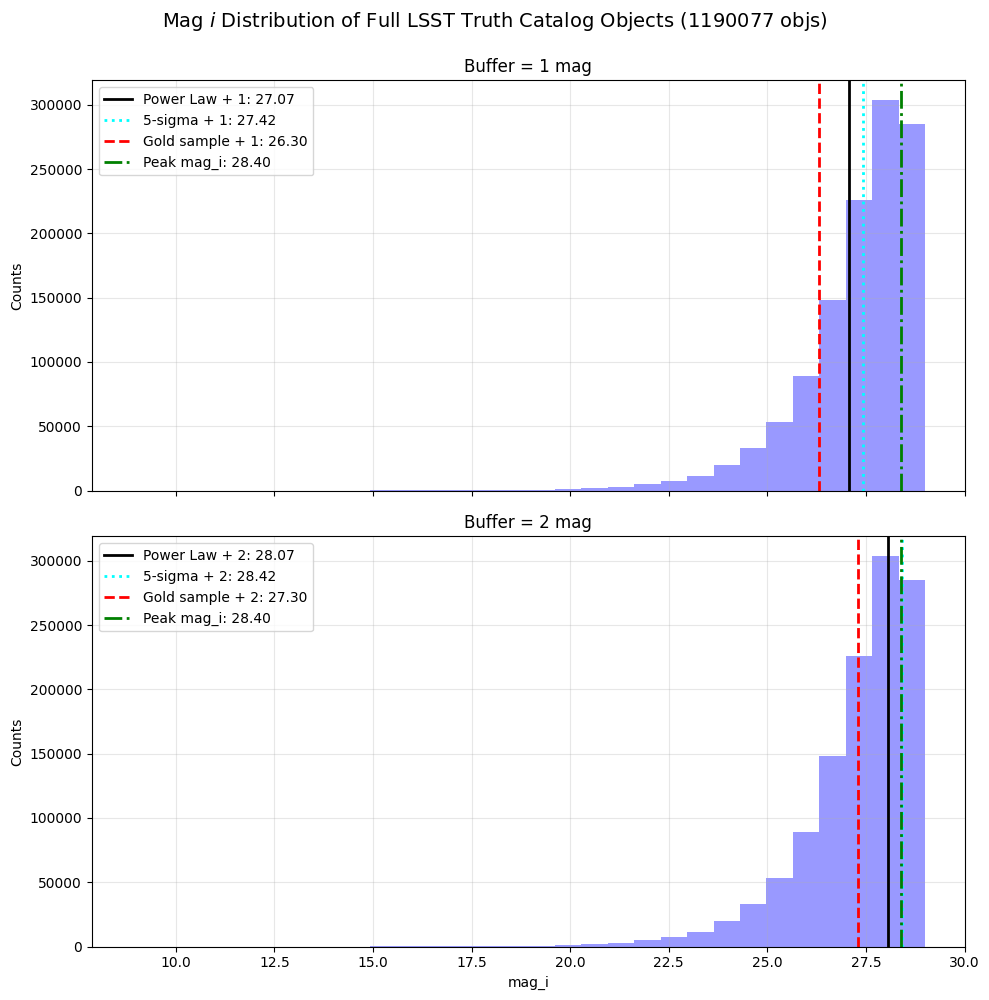

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax1.axvline(mag_limit + 1, color='black', linestyle='solid', linewidth=2, label=f'Power Law + 1: {mag_limit + 1:.2f}')
ax1.axvline(given_mag_limit + 1, color='cyan', linestyle=':', linewidth=2, label=f'5-sigma + 1: {given_mag_limit + 1:.2f}')
ax1.axvline(25.3 + 1, color='red', linestyle='--', linewidth=2, label=f'Gold sample + 1: {26.3:.2f}')
ax1.axvline(peak_mag, color='green', linestyle='-.', linewidth=2, label=f'Peak mag_i: {peak_mag:.2f}')
ax1.hist(full_truth_cat['mag_i'].values, bins=30, alpha=0.4, color='blue')
ax1.set_ylabel('Counts')
ax1.set_title('Buffer = 1 mag')
ax1.legend()
ax1.grid(True, alpha=0.3)

# buffer = 2
ax2.axvline(mag_limit + 2, color='black', linestyle='solid', linewidth=2, label=f'Power Law + 2: {mag_limit + 2:.2f}')
ax2.axvline(given_mag_limit + 2, color='cyan', linestyle=':', linewidth=2, label=f'5-sigma + 2: {given_mag_limit + 2:.2f}')
ax2.axvline(25.3 + 2, color='red', linestyle='--', linewidth=2, label=f'Gold sample + 2: {27.3:.2f}')
ax2.axvline(peak_mag, color='green', linestyle='-.', linewidth=2, label=f'Peak mag_i: {peak_mag:.2f}')
ax2.hist(full_truth_cat['mag_i'].values, bins=30, alpha=0.4, color='blue')
ax2.set_xlabel('mag_i')
ax2.set_ylabel('Counts')
ax2.set_title('Buffer = 2 mag')
ax2.legend()
ax2.grid(True, alpha=0.3)
fig.suptitle(f"Mag $i$ Distribution of Full LSST Truth Catalog Objects ({len(full_truth_cat)} objs)", fontsize=14, y=0.995)
plt.tight_layout()

In [ ]:
maglim_truth_cat = pd.read_parquet(f'{os.path.expanduser("~")}/lsst_runs/{run_name}/test_cats/test_truth_cat_maglim_27.07.parquet')

In [45]:
maglim_truth_cat['mag_i'].describe()

count    398213.000000
mean         25.712154
std           1.380645
min           8.881651
25%          25.200741
50%          26.142265
75%          26.682335
max          27.068554
Name: mag_i, dtype: float64

In [44]:
counts, bin_edges = np.histogram(maglim_truth_cat[np.isfinite(maglim_truth_cat['mag_i'])]['mag_i'].values, bins=50)
# bin with highest count
peak_bin_index = np.argmax(counts)
# since bin edges give you (bins+1) edges, we do +1 to get center of peak bin
peak_mag = (bin_edges[peak_bin_index] + bin_edges[peak_bin_index + 1]) / 2
peak_mag

np.float64(26.886684894600997)

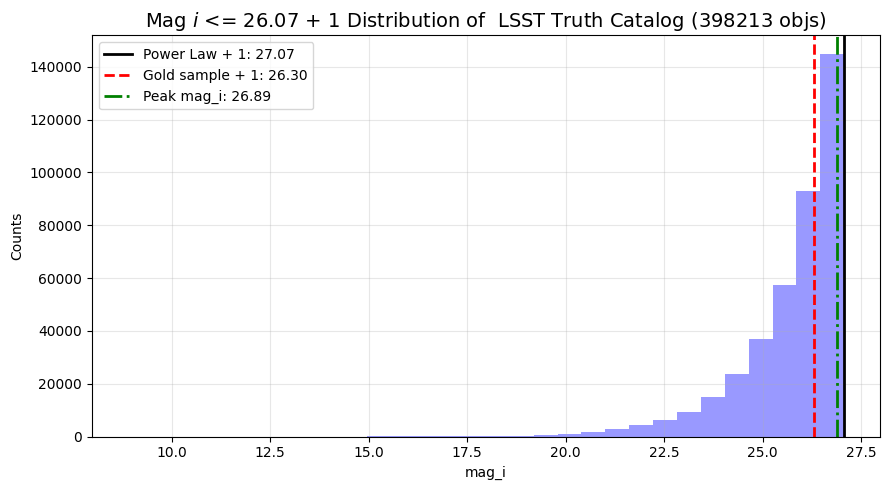

In [52]:
plt.figure(figsize=(9, 5))
plt.axvline(mag_limit + 1, color='black', linestyle='solid', linewidth=2, label=f'Power Law + 1: {mag_limit + 1:.2f}')
plt.axvline(25.3 + 1, color='red', linestyle='--', linewidth=2, label=f'Gold sample + 1: {26.3:.2f}')
plt.axvline(peak_mag, color='green', linestyle='-.', linewidth=2, label=f'Peak mag_i: {peak_mag:.2f}')
plt.hist(maglim_truth_cat['mag_i'].values, bins=30, alpha=0.4, color='blue')
plt.xlabel('mag_i')
plt.ylabel('Counts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title(f"Mag $i$ <= 26.07 + 1 Distribution of  LSST Truth Catalog ({len(maglim_truth_cat)} objs)", fontsize=14)
plt.tight_layout()

# Exploring LSST Truth Catalog of Objects with Ground Truth Labels

Looks like ~27.65 was the faintest galaxy that DeepDISC was trained on. Mean was 25.16 and the peak of most objects was around 26.